# Conditional Neural Processes (CNP) for Coherent.
[Conditional Neural Processes](https://arxiv.org/pdf/1807.01613.pdf) (CNPs) were
introduced as a continuation of
[Generative Query Networks](https://deepmind.com/blog/neural-scene-representation-and-rendering/)
(GQN) to extend its training regime to tasks beyond scene rendering, e.g. to
regression and classification.

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import datetime
import numpy as np
import pandas as pd
import os
from resum.utilities import plotting_utils_cnp as plotting
from resum.utilities import utilities as utils
from resum.conditional_neural_process import DataGeneration
from resum.conditional_neural_process import DeterministicModel
from torch.utils.tensorboard import SummaryWriter
import csv
import yaml

In [5]:
with open("../coherent/settings.yaml", "r") as f:
    config_file = yaml.safe_load(f)

PLOT_AFTER = int(config_file["cnp_settings"]["plot_after"])
torch.manual_seed(0)
FILES_PER_BATCH = config_file["cnp_settings"]["files_per_batch_predict"]
target_range = config_file["simulation_settings"]["target_range"]
is_binary = target_range[0] >= 0 and target_range[1] <= 1

path_out  = config_file["path_settings"]["path_out_cnp"]
version   = config_file["path_settings"]["version"]
iteration = config_file["path_settings"]["iteration"]
fidelity  = config_file["path_settings"]["fidelity"]



In [6]:
x_size, y_size = utils.get_feature_and_label_size(config_file)
theta_size=len(config_file["simulation_settings"]["theta_headers"])

In [7]:
d_x, d_in, representation_size, d_out = x_size , x_size+y_size, 32, y_size+1
encoder_sizes = [d_in, 32, 64, 128, 128, 128, 64, 48, representation_size]
decoder_sizes = [representation_size + d_x, 32, 64, 128, 128, 128, 64, 48, d_out]

model = DeterministicModel(encoder_sizes,decoder_sizes)
model.load_state_dict(torch.load(f'{path_out}/cnp_{version}_model.pth'))
model.eval()

DeterministicModel(
  (_encoder): DeterministicEncoder(
    (linears): ModuleList(
      (0): Linear(in_features=12, out_features=32, bias=True)
      (1): Linear(in_features=32, out_features=64, bias=True)
      (2): Linear(in_features=64, out_features=128, bias=True)
      (3-4): 2 x Linear(in_features=128, out_features=128, bias=True)
      (5): Linear(in_features=128, out_features=64, bias=True)
      (6): Linear(in_features=64, out_features=48, bias=True)
      (7): Linear(in_features=48, out_features=32, bias=True)
    )
  )
  (_decoder): DeterministicDecoder(
    (linears): ModuleList(
      (0): Linear(in_features=43, out_features=32, bias=True)
      (1): Linear(in_features=32, out_features=64, bias=True)
      (2): Linear(in_features=64, out_features=128, bias=True)
      (3-4): 2 x Linear(in_features=128, out_features=128, bias=True)
      (5): Linear(in_features=128, out_features=64, bias=True)
      (6): Linear(in_features=64, out_features=48, bias=True)
      (7): Linear(

In [9]:
import traceback

bce = nn.BCELoss()
iter_predict = 0
error_log = []          # collect every failure we meet

for p, path in enumerate(config_file["path_settings"]["path_to_files_predict"]):
    USE_DATA_AUGMENTATION = False
    
    # load data
    dataset_predict = DataGeneration(
        mode="testing",
        config_file=config_file,
        path_to_files=path,
        use_data_augmentation=USE_DATA_AUGMENTATION,
        batch_size=config_file["cnp_settings"]["batch_size_predict"][p],
        files_per_batch=FILES_PER_BATCH
    )
    dataset_predict.set_loader()
    dataloader_predict = dataset_predict.dataloader

    for b, batch in enumerate(dataloader_predict):
        try:
            batch_formated = dataset_predict.format_batch_for_cnp(
                batch, config_file["cnp_settings"]["context_is_subset"]
            )

            # forward pass
            log_prob, mu, sigma = model(
                batch_formated.query,
                batch_formated.target_y,
                is_binary
            )

            # loss (just to run exactly what you normally do)
            loss = -log_prob.mean()
            loss_bce = bce(mu, batch_formated.target_y) if is_binary else -1

        except Exception as e:
            # record and display the failure
            err_msg = (
                f"\n[ERROR] file idx={p}, path={path}\n"
                f"        batch idx={b}, iter_predict={iter_predict}\n"
                f"        exception={type(e).__name__}: {e}"
            )
            print(err_msg)
            traceback.print_exc(limit=2)   # short traceback
            error_log.append((p, path, b, iter_predict, e))
            # comment‐out the next line if you want to keep running after an error
            # break
        finally:
            iter_predict += 1

# Quick summary once everything is done
print(f"\nFinished scan – {len(error_log)} batch(es) failed.")
for p, path, b, it, e in error_log:
    print(f"  file idx={p}  batch idx={b}  iter={it}  --> {type(e).__name__}: {e}")


[ERROR] file idx=0, path=../coherent/in/data/processed/lf/
        batch idx=220, iter_predict=220
        exception=IndexError: too many indices for tensor of dimension 1

[ERROR] file idx=0, path=../coherent/in/data/processed/lf/
        batch idx=228, iter_predict=228
        exception=IndexError: too many indices for tensor of dimension 1


Traceback (most recent call last):
  File "/tmp/ipykernel_1478463/959605341.py", line 24, in <module>
    batch_formated = dataset_predict.format_batch_for_cnp(
                     ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/bliu4/resum-coherent2/resum/conditional_neural_process/data_generator.py", line 381, in format_batch_for_cnp
    batch_x = batch[:,:self.feature_size]  # All features except last column (input features)
              ~~~~~^^^^^^^^^^^^^^^^^^^^^^
IndexError: too many indices for tensor of dimension 1
Traceback (most recent call last):
  File "/tmp/ipykernel_1478463/959605341.py", line 24, in <module>
    batch_formated = dataset_predict.format_batch_for_cnp(
                     ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/bliu4/resum-coherent2/resum/conditional_neural_process/data_generator.py", line 381, in format_batch_for_cnp
    batch_x = batch[:,:self.feature_size]  # All features except last column (input features)
              ~~~~~^^^^^^^^^^


[ERROR] file idx=0, path=../coherent/in/data/processed/lf/
        batch idx=231, iter_predict=231
        exception=IndexError: too many indices for tensor of dimension 1

[ERROR] file idx=0, path=../coherent/in/data/processed/lf/
        batch idx=232, iter_predict=232
        exception=IndexError: too many indices for tensor of dimension 1

[ERROR] file idx=0, path=../coherent/in/data/processed/lf/
        batch idx=236, iter_predict=236
        exception=IndexError: too many indices for tensor of dimension 1

[ERROR] file idx=0, path=../coherent/in/data/processed/lf/
        batch idx=239, iter_predict=239
        exception=IndexError: too many indices for tensor of dimension 1

[ERROR] file idx=0, path=../coherent/in/data/processed/lf/
        batch idx=240, iter_predict=240
        exception=IndexError: too many indices for tensor of dimension 1


Traceback (most recent call last):
  File "/tmp/ipykernel_1478463/959605341.py", line 24, in <module>
    batch_formated = dataset_predict.format_batch_for_cnp(
                     ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/bliu4/resum-coherent2/resum/conditional_neural_process/data_generator.py", line 381, in format_batch_for_cnp
    batch_x = batch[:,:self.feature_size]  # All features except last column (input features)
              ~~~~~^^^^^^^^^^^^^^^^^^^^^^
IndexError: too many indices for tensor of dimension 1
Traceback (most recent call last):
  File "/tmp/ipykernel_1478463/959605341.py", line 24, in <module>
    batch_formated = dataset_predict.format_batch_for_cnp(
                     ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/bliu4/resum-coherent2/resum/conditional_neural_process/data_generator.py", line 381, in format_batch_for_cnp
    batch_x = batch[:,:self.feature_size]  # All features except last column (input features)
              ~~~~~^^^^^^^^^^


[ERROR] file idx=0, path=../coherent/in/data/processed/lf/
        batch idx=244, iter_predict=244
        exception=IndexError: too many indices for tensor of dimension 1

[ERROR] file idx=0, path=../coherent/in/data/processed/lf/
        batch idx=247, iter_predict=247
        exception=IndexError: too many indices for tensor of dimension 1

[ERROR] file idx=0, path=../coherent/in/data/processed/lf/
        batch idx=248, iter_predict=248
        exception=IndexError: too many indices for tensor of dimension 1

[ERROR] file idx=0, path=../coherent/in/data/processed/lf/
        batch idx=251, iter_predict=251
        exception=IndexError: too many indices for tensor of dimension 1

[ERROR] file idx=0, path=../coherent/in/data/processed/lf/
        batch idx=252, iter_predict=252
        exception=IndexError: too many indices for tensor of dimension 1


Traceback (most recent call last):
  File "/tmp/ipykernel_1478463/959605341.py", line 24, in <module>
    batch_formated = dataset_predict.format_batch_for_cnp(
                     ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/bliu4/resum-coherent2/resum/conditional_neural_process/data_generator.py", line 381, in format_batch_for_cnp
    batch_x = batch[:,:self.feature_size]  # All features except last column (input features)
              ~~~~~^^^^^^^^^^^^^^^^^^^^^^
IndexError: too many indices for tensor of dimension 1
Traceback (most recent call last):
  File "/tmp/ipykernel_1478463/959605341.py", line 24, in <module>
    batch_formated = dataset_predict.format_batch_for_cnp(
                     ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/bliu4/resum-coherent2/resum/conditional_neural_process/data_generator.py", line 381, in format_batch_for_cnp
    batch_x = batch[:,:self.feature_size]  # All features except last column (input features)
              ~~~~~^^^^^^^^^^


[ERROR] file idx=0, path=../coherent/in/data/processed/lf/
        batch idx=255, iter_predict=255
        exception=IndexError: too many indices for tensor of dimension 1

[ERROR] file idx=0, path=../coherent/in/data/processed/lf/
        batch idx=256, iter_predict=256
        exception=IndexError: too many indices for tensor of dimension 1


Traceback (most recent call last):
  File "/tmp/ipykernel_1478463/959605341.py", line 24, in <module>
    batch_formated = dataset_predict.format_batch_for_cnp(
                     ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/bliu4/resum-coherent2/resum/conditional_neural_process/data_generator.py", line 381, in format_batch_for_cnp
    batch_x = batch[:,:self.feature_size]  # All features except last column (input features)
              ~~~~~^^^^^^^^^^^^^^^^^^^^^^
IndexError: too many indices for tensor of dimension 1
Traceback (most recent call last):
  File "/tmp/ipykernel_1478463/959605341.py", line 24, in <module>
    batch_formated = dataset_predict.format_batch_for_cnp(
                     ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/bliu4/resum-coherent2/resum/conditional_neural_process/data_generator.py", line 381, in format_batch_for_cnp
    batch_x = batch[:,:self.feature_size]  # All features except last column (input features)
              ~~~~~^^^^^^^^^^

Finished full dataset pass. Starting new epoch! 

[ERROR] file idx=0, path=../coherent/in/data/processed/lf/
        batch idx=259, iter_predict=259
        exception=IndexError: too many indices for tensor of dimension 1

[ERROR] file idx=0, path=../coherent/in/data/processed/lf/
        batch idx=260, iter_predict=260
        exception=IndexError: too many indices for tensor of dimension 1

[ERROR] file idx=0, path=../coherent/in/data/processed/lf/
        batch idx=262, iter_predict=262
        exception=IndexError: too many indices for tensor of dimension 1

[ERROR] file idx=0, path=../coherent/in/data/processed/lf/
        batch idx=263, iter_predict=263
        exception=IndexError: too many indices for tensor of dimension 1

[ERROR] file idx=0, path=../coherent/in/data/processed/lf/
        batch idx=264, iter_predict=264
        exception=IndexError: too many indices for tensor of dimension 1

[ERROR] file idx=0, path=../coherent/in/data/processed/lf/
        batch idx=265, ite

Traceback (most recent call last):
  File "/tmp/ipykernel_1478463/959605341.py", line 24, in <module>
    batch_formated = dataset_predict.format_batch_for_cnp(
                     ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/bliu4/resum-coherent2/resum/conditional_neural_process/data_generator.py", line 381, in format_batch_for_cnp
    batch_x = batch[:,:self.feature_size]  # All features except last column (input features)
              ~~~~~^^^^^^^^^^^^^^^^^^^^^^
IndexError: too many indices for tensor of dimension 1
Traceback (most recent call last):
  File "/tmp/ipykernel_1478463/959605341.py", line 24, in <module>
    batch_formated = dataset_predict.format_batch_for_cnp(
                     ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/bliu4/resum-coherent2/resum/conditional_neural_process/data_generator.py", line 381, in format_batch_for_cnp
    batch_x = batch[:,:self.feature_size]  # All features except last column (input features)
              ~~~~~^^^^^^^^^^


[ERROR] file idx=1, path=../coherent/in/data/processed/hf/
        batch idx=166, iter_predict=438
        exception=IndexError: too many indices for tensor of dimension 1

[ERROR] file idx=1, path=../coherent/in/data/processed/hf/
        batch idx=169, iter_predict=441
        exception=IndexError: too many indices for tensor of dimension 1

[ERROR] file idx=1, path=../coherent/in/data/processed/hf/
        batch idx=172, iter_predict=444
        exception=IndexError: too many indices for tensor of dimension 1


Traceback (most recent call last):
  File "/tmp/ipykernel_1478463/959605341.py", line 24, in <module>
    batch_formated = dataset_predict.format_batch_for_cnp(
                     ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/bliu4/resum-coherent2/resum/conditional_neural_process/data_generator.py", line 381, in format_batch_for_cnp
    batch_x = batch[:,:self.feature_size]  # All features except last column (input features)
              ~~~~~^^^^^^^^^^^^^^^^^^^^^^
IndexError: too many indices for tensor of dimension 1
Traceback (most recent call last):
  File "/tmp/ipykernel_1478463/959605341.py", line 24, in <module>
    batch_formated = dataset_predict.format_batch_for_cnp(
                     ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/bliu4/resum-coherent2/resum/conditional_neural_process/data_generator.py", line 381, in format_batch_for_cnp
    batch_x = batch[:,:self.feature_size]  # All features except last column (input features)
              ~~~~~^^^^^^^^^^


[ERROR] file idx=1, path=../coherent/in/data/processed/hf/
        batch idx=175, iter_predict=447
        exception=IndexError: too many indices for tensor of dimension 1

[ERROR] file idx=1, path=../coherent/in/data/processed/hf/
        batch idx=178, iter_predict=450
        exception=IndexError: too many indices for tensor of dimension 1

[ERROR] file idx=1, path=../coherent/in/data/processed/hf/
        batch idx=181, iter_predict=453
        exception=IndexError: too many indices for tensor of dimension 1


Traceback (most recent call last):
  File "/tmp/ipykernel_1478463/959605341.py", line 24, in <module>
    batch_formated = dataset_predict.format_batch_for_cnp(
                     ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/bliu4/resum-coherent2/resum/conditional_neural_process/data_generator.py", line 381, in format_batch_for_cnp
    batch_x = batch[:,:self.feature_size]  # All features except last column (input features)
              ~~~~~^^^^^^^^^^^^^^^^^^^^^^
IndexError: too many indices for tensor of dimension 1
Traceback (most recent call last):
  File "/tmp/ipykernel_1478463/959605341.py", line 24, in <module>
    batch_formated = dataset_predict.format_batch_for_cnp(
                     ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/bliu4/resum-coherent2/resum/conditional_neural_process/data_generator.py", line 381, in format_batch_for_cnp
    batch_x = batch[:,:self.feature_size]  # All features except last column (input features)
              ~~~~~^^^^^^^^^^


[ERROR] file idx=1, path=../coherent/in/data/processed/hf/
        batch idx=184, iter_predict=456
        exception=IndexError: too many indices for tensor of dimension 1

[ERROR] file idx=1, path=../coherent/in/data/processed/hf/
        batch idx=187, iter_predict=459
        exception=IndexError: too many indices for tensor of dimension 1

[ERROR] file idx=1, path=../coherent/in/data/processed/hf/
        batch idx=190, iter_predict=462
        exception=IndexError: too many indices for tensor of dimension 1


Traceback (most recent call last):
  File "/tmp/ipykernel_1478463/959605341.py", line 24, in <module>
    batch_formated = dataset_predict.format_batch_for_cnp(
                     ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/bliu4/resum-coherent2/resum/conditional_neural_process/data_generator.py", line 381, in format_batch_for_cnp
    batch_x = batch[:,:self.feature_size]  # All features except last column (input features)
              ~~~~~^^^^^^^^^^^^^^^^^^^^^^
IndexError: too many indices for tensor of dimension 1
Traceback (most recent call last):
  File "/tmp/ipykernel_1478463/959605341.py", line 24, in <module>
    batch_formated = dataset_predict.format_batch_for_cnp(
                     ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/bliu4/resum-coherent2/resum/conditional_neural_process/data_generator.py", line 381, in format_batch_for_cnp
    batch_x = batch[:,:self.feature_size]  # All features except last column (input features)
              ~~~~~^^^^^^^^^^

Finished full dataset pass. Starting new epoch! 

[ERROR] file idx=1, path=../coherent/in/data/processed/hf/
        batch idx=193, iter_predict=465
        exception=IndexError: too many indices for tensor of dimension 1

[ERROR] file idx=1, path=../coherent/in/data/processed/hf/
        batch idx=196, iter_predict=468
        exception=IndexError: too many indices for tensor of dimension 1

[ERROR] file idx=1, path=../coherent/in/data/processed/hf/
        batch idx=197, iter_predict=469
        exception=IndexError: too many indices for tensor of dimension 1

Finished scan – 37 batch(es) failed.
  file idx=0  batch idx=220  iter=220  --> IndexError: too many indices for tensor of dimension 1
  file idx=0  batch idx=228  iter=228  --> IndexError: too many indices for tensor of dimension 1
  file idx=0  batch idx=231  iter=231  --> IndexError: too many indices for tensor of dimension 1
  file idx=0  batch idx=232  iter=232  --> IndexError: too many indices for tensor of dimension 1
  

Traceback (most recent call last):
  File "/tmp/ipykernel_1478463/959605341.py", line 24, in <module>
    batch_formated = dataset_predict.format_batch_for_cnp(
                     ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/bliu4/resum-coherent2/resum/conditional_neural_process/data_generator.py", line 381, in format_batch_for_cnp
    batch_x = batch[:,:self.feature_size]  # All features except last column (input features)
              ~~~~~^^^^^^^^^^^^^^^^^^^^^^
IndexError: too many indices for tensor of dimension 1
Traceback (most recent call last):
  File "/tmp/ipykernel_1478463/959605341.py", line 24, in <module>
    batch_formated = dataset_predict.format_batch_for_cnp(
                     ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/bliu4/resum-coherent2/resum/conditional_neural_process/data_generator.py", line 381, in format_batch_for_cnp
    batch_x = batch[:,:self.feature_size]  # All features except last column (input features)
              ~~~~~^^^^^^^^^^

0
2025-06-25 01:03:41 Iteration: 0/0, train loss: 0.6108 (vs BCE 0.2040)


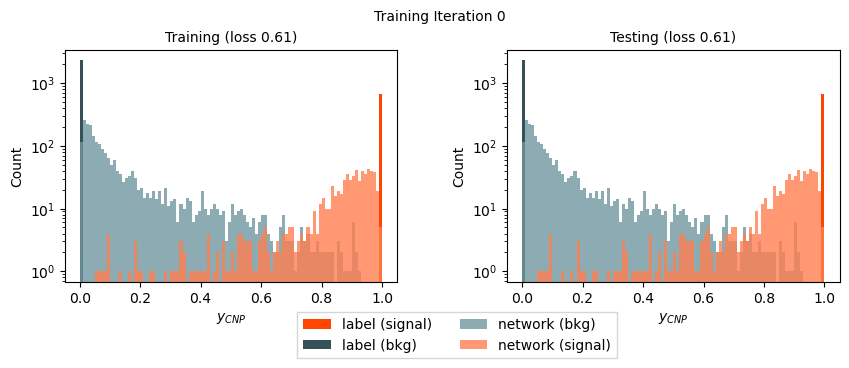

<built-in function iter>
<built-in function iter>
<built-in function iter>
<built-in function iter>
<built-in function iter>
<built-in function iter>
<built-in function iter>
<built-in function iter>
<built-in function iter>
<built-in function iter>
<built-in function iter>
<built-in function iter>
<built-in function iter>
<built-in function iter>
<built-in function iter>
<built-in function iter>
<built-in function iter>
<built-in function iter>
<built-in function iter>
<built-in function iter>
<built-in function iter>
<built-in function iter>
<built-in function iter>
<built-in function iter>
<built-in function iter>
<built-in function iter>
<built-in function iter>
<built-in function iter>
<built-in function iter>
<built-in function iter>
<built-in function iter>
<built-in function iter>
<built-in function iter>
<built-in function iter>
<built-in function iter>
<built-in function iter>
<built-in function iter>
<built-in function iter>
<built-in function iter>
<built-in function iter>


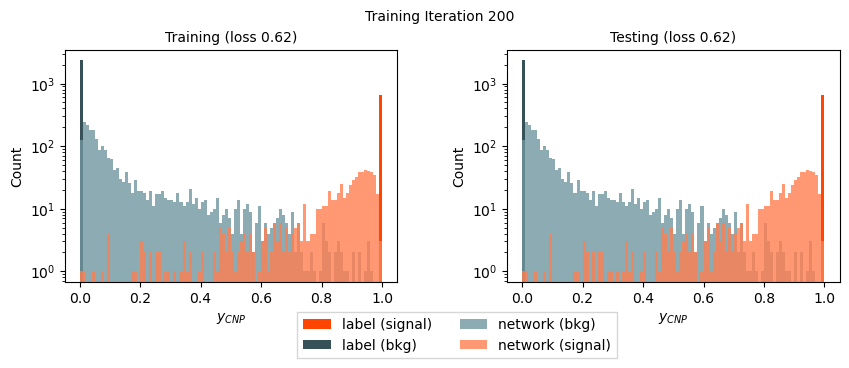

<built-in function iter>
<built-in function iter>
<built-in function iter>
<built-in function iter>
<built-in function iter>
<built-in function iter>
<built-in function iter>
<built-in function iter>
<built-in function iter>
<built-in function iter>
<built-in function iter>
<built-in function iter>
<built-in function iter>
<built-in function iter>
<built-in function iter>
<built-in function iter>
<built-in function iter>
<built-in function iter>
<built-in function iter>
<built-in function iter>
<built-in function iter>
<built-in function iter>
<built-in function iter>
<built-in function iter>
<built-in function iter>
<built-in function iter>
<built-in function iter>
<built-in function iter>
<built-in function iter>
<built-in function iter>
<built-in function iter>
<built-in function iter>
<built-in function iter>
<built-in function iter>
<built-in function iter>
<built-in function iter>
<built-in function iter>
<built-in function iter>
<built-in function iter>
<built-in function iter>


IndexError: too many indices for tensor of dimension 1

In [ ]:
bce = nn.BCELoss()
iter_predict = 0

# create a PdfPages object
test_idx=0
it_batch = 0

with open(f'{path_out}/cnp_{version}_output.csv', mode='w', newline='') as file:
    writer = csv.writer(file)
    headers = ['iteration','fidelity','n_samples'] + [*config_file["simulation_settings"]["theta_headers"]] + ['y_cnp', 'y_cnp_err', 'y_raw', 'log_prop','bce']
    writer.writerow(headers)

for p, path in enumerate(config_file["path_settings"]["path_to_files_predict"]):
    USE_DATA_AUGMENTATION = False
    # load data:

    dataset_predict = DataGeneration(mode = "testing", config_file=config_file, 
                                   path_to_files=path, 
                                   use_data_augmentation=USE_DATA_AUGMENTATION, 
                                   batch_size=config_file["cnp_settings"]["batch_size_predict"][p], 
                                   files_per_batch=FILES_PER_BATCH)
    dataset_predict.set_loader()
    dataloader_predict = dataset_predict.dataloader


    #it_batch = 0
    
    for b, batch in enumerate(dataloader_predict):
        batch_formated=dataset_predict.format_batch_for_cnp(batch,config_file["cnp_settings"]["context_is_subset"] )
        # Get the predicted mean and variance at the target points for the testing set
        log_prob, mu, sigma = model(batch_formated.query, batch_formated.target_y, is_binary)
        
        # Define the loss
        loss = -log_prob.mean()
        
        if is_binary:
            loss_bce = bce(mu, batch_formated.target_y)
        else:
            loss_bce=-1

        
        
        mu=mu[0].detach().numpy()
        sigma = sigma[0].detach().numpy()

        theta=batch_formated.query[1][0].detach().numpy()
        print(iter_predict)
        row = np.array([iteration[p]] + [fidelity[p]] + [len(mu)] + theta[0,:theta_size].tolist() + [np.mean(mu), np.sqrt(np.sum(sigma**2)) / len(sigma), np.mean(batch_formated.target_y.detach().numpy()),loss.item(), loss_bce.item()])
        # Reshape to 2D array (one row)
        row = row.reshape(1, -1)

        # Write the row to the CSV file with 5 decimal places for each number
        with open(f'{path_out}/cnp_{version}_output.csv', mode='a', newline='') as file:
            np.savetxt(file, row, delimiter=",", fmt="%.5f")

        if it_batch % PLOT_AFTER == 0:
            mu_predict=mu
            loss_predict=loss
            print('{} Iteration: {}/{}, train loss: {:.4f} (vs BCE {:.4f})'.format(datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"),p, it_batch,loss, loss_bce))
            if y_size ==1:
                    fig = plotting.plot(mu, batch_formated.target_y[0].detach().numpy(), f'{loss:.2f}', mu_predict, batch_formated.target_y[0].detach().numpy(), f'{loss_predict:.2f}', target_range, it_batch)
            else:
                for k in range(y_size):
                        fig = plotting.plot(mu[:,k], batch_formated.target_y[0].detach().numpy()[:,k], f'{loss:.2f}', mu_predict[:,k], batch_formated.target_y[0].detach().numpy()[:,k], f'{loss_predict:.2f}', target_range, it_batch)
                        
        it_batch+=1
        iter_predict+=1


0
2025-06-25 01:03:41 Iteration: 0/0, train loss: 0.6108 (vs BCE 0.2040)


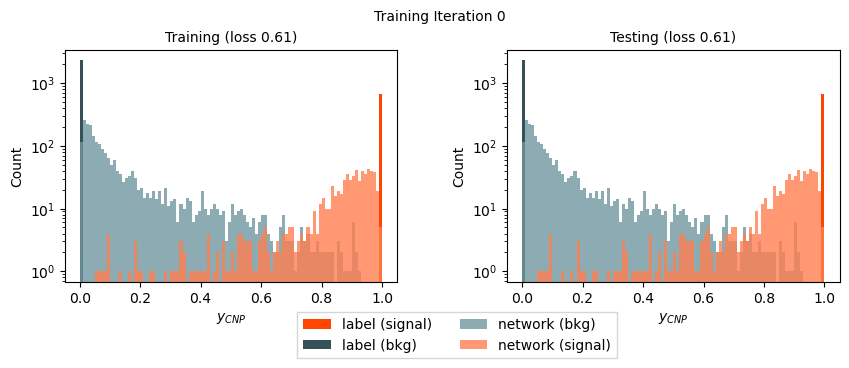

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
2025-06-25 01:03:48 Iteration: 0/200, train loss: 0.6168 (vs BCE 0.2201)


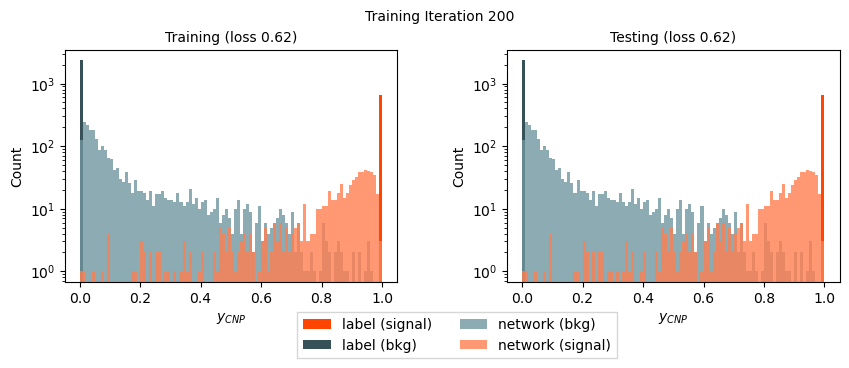

201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219


IndexError: too many indices for tensor of dimension 1

In [ ]:
bce = nn.BCELoss()
iter_predict = 0

# create a PdfPages object
test_idx=0
it_batch = 0

with open(f'{path_out}/cnp_{version}_output.csv', mode='w', newline='') as file:
    writer = csv.writer(file)
    headers = ['iteration','fidelity','n_samples'] + [*config_file["simulation_settings"]["theta_headers"]] + ['y_cnp', 'y_cnp_err', 'y_raw', 'log_prop','bce']
    writer.writerow(headers)

for p, path in enumerate(config_file["path_settings"]["path_to_files_predict"]):
    USE_DATA_AUGMENTATION = False
    # load data:

    dataset_predict = DataGeneration(mode = "testing", config_file=config_file, 
                                   path_to_files=path, 
                                   use_data_augmentation=USE_DATA_AUGMENTATION, 
                                   batch_size=config_file["cnp_settings"]["batch_size_predict"][p], 
                                   files_per_batch=FILES_PER_BATCH)
    dataset_predict.set_loader()
    dataloader_predict = dataset_predict.dataloader


    #it_batch = 0
    
    for b, batch in enumerate(dataloader_predict):
        batch_formated=dataset_predict.format_batch_for_cnp(batch,config_file["cnp_settings"]["context_is_subset"] )
        # Get the predicted mean and variance at the target points for the testing set
        log_prob, mu, sigma = model(batch_formated.query, batch_formated.target_y, is_binary)
        
        # Define the loss
        loss = -log_prob.mean()
        
        if is_binary:
            loss_bce = bce(mu, batch_formated.target_y)
        else:
            loss_bce=-1

        
        
        mu=mu[0].detach().numpy()
        sigma = sigma[0].detach().numpy()

        theta=batch_formated.query[1][0].detach().numpy()
        print(iter_predict)
        row = np.array([iteration[p]] + [fidelity[p]] + [len(mu)] + theta[0,:theta_size].tolist() + [np.mean(mu), np.sqrt(np.sum(sigma**2)) / len(sigma), np.mean(batch_formated.target_y.detach().numpy()),loss.item(), loss_bce.item()])
        # Reshape to 2D array (one row)
        row = row.reshape(1, -1)

        # Write the row to the CSV file with 5 decimal places for each number
        with open(f'{path_out}/cnp_{version}_output.csv', mode='a', newline='') as file:
            np.savetxt(file, row, delimiter=",", fmt="%.5f")

        if it_batch % PLOT_AFTER == 0:
            mu_predict=mu
            loss_predict=loss
            print('{} Iteration: {}/{}, train loss: {:.4f} (vs BCE {:.4f})'.format(datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"),p, it_batch,loss, loss_bce))
            if y_size ==1:
                    fig = plotting.plot(mu, batch_formated.target_y[0].detach().numpy(), f'{loss:.2f}', mu_predict, batch_formated.target_y[0].detach().numpy(), f'{loss_predict:.2f}', target_range, it_batch)
            else:
                for k in range(y_size):
                        fig = plotting.plot(mu[:,k], batch_formated.target_y[0].detach().numpy()[:,k], f'{loss:.2f}', mu_predict[:,k], batch_formated.target_y[0].detach().numpy()[:,k], f'{loss_predict:.2f}', target_range, it_batch)
                        
        it_batch+=1
        iter_predict+=1


0
2025-06-25 01:03:41 Iteration: 0/0, train loss: 0.6108 (vs BCE 0.2040)


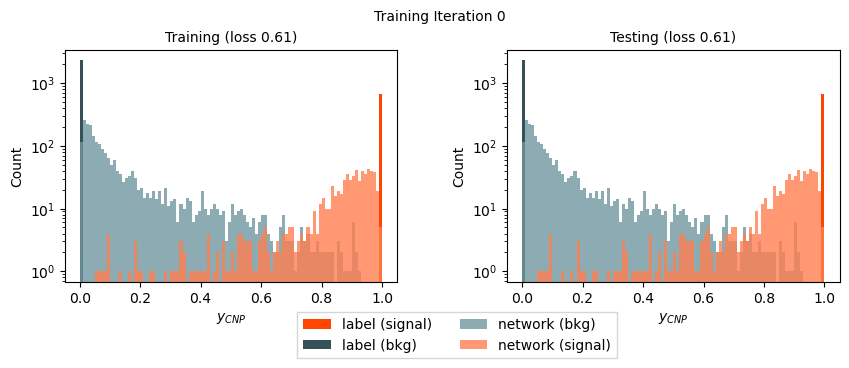

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
2025-06-25 01:03:48 Iteration: 0/200, train loss: 0.6168 (vs BCE 0.2201)


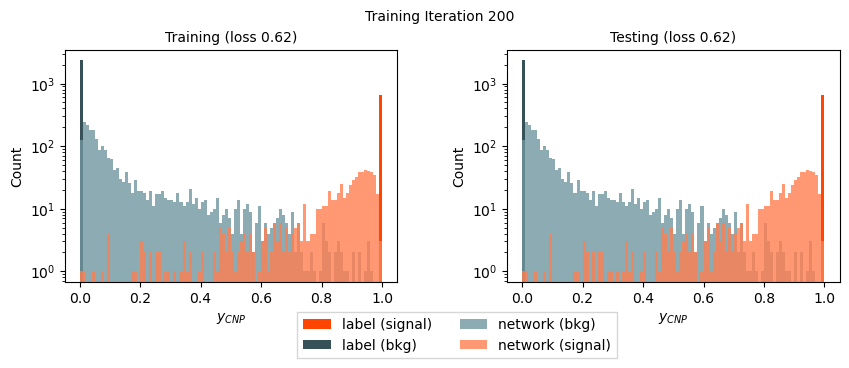

201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219


IndexError: too many indices for tensor of dimension 1

In [ ]:
bce = nn.BCELoss()
iter_predict = 0

# create a PdfPages object
test_idx=0
it_batch = 0

with open(f'{path_out}/cnp_{version}_output.csv', mode='w', newline='') as file:
    writer = csv.writer(file)
    headers = ['iteration','fidelity','n_samples'] + [*config_file["simulation_settings"]["theta_headers"]] + ['y_cnp', 'y_cnp_err', 'y_raw', 'log_prop','bce']
    writer.writerow(headers)

for p, path in enumerate(config_file["path_settings"]["path_to_files_predict"]):
    USE_DATA_AUGMENTATION = False
    # load data:

    dataset_predict = DataGeneration(mode = "testing", config_file=config_file, 
                                   path_to_files=path, 
                                   use_data_augmentation=USE_DATA_AUGMENTATION, 
                                   batch_size=config_file["cnp_settings"]["batch_size_predict"][p], 
                                   files_per_batch=FILES_PER_BATCH)
    dataset_predict.set_loader()
    dataloader_predict = dataset_predict.dataloader


    #it_batch = 0
    
    for b, batch in enumerate(dataloader_predict):
        batch_formated=dataset_predict.format_batch_for_cnp(batch,config_file["cnp_settings"]["context_is_subset"] )
        # Get the predicted mean and variance at the target points for the testing set
        log_prob, mu, sigma = model(batch_formated.query, batch_formated.target_y, is_binary)
        
        # Define the loss
        loss = -log_prob.mean()
        
        if is_binary:
            loss_bce = bce(mu, batch_formated.target_y)
        else:
            loss_bce=-1

        
        
        mu=mu[0].detach().numpy()
        sigma = sigma[0].detach().numpy()

        theta=batch_formated.query[1][0].detach().numpy()
        print(iter_predict)
        row = np.array([iteration[p]] + [fidelity[p]] + [len(mu)] + theta[0,:theta_size].tolist() + [np.mean(mu), np.sqrt(np.sum(sigma**2)) / len(sigma), np.mean(batch_formated.target_y.detach().numpy()),loss.item(), loss_bce.item()])
        # Reshape to 2D array (one row)
        row = row.reshape(1, -1)

        # Write the row to the CSV file with 5 decimal places for each number
        with open(f'{path_out}/cnp_{version}_output.csv', mode='a', newline='') as file:
            np.savetxt(file, row, delimiter=",", fmt="%.5f")

        if it_batch % PLOT_AFTER == 0:
            mu_predict=mu
            loss_predict=loss
            print('{} Iteration: {}/{}, train loss: {:.4f} (vs BCE {:.4f})'.format(datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"),p, it_batch,loss, loss_bce))
            if y_size ==1:
                    fig = plotting.plot(mu, batch_formated.target_y[0].detach().numpy(), f'{loss:.2f}', mu_predict, batch_formated.target_y[0].detach().numpy(), f'{loss_predict:.2f}', target_range, it_batch)
            else:
                for k in range(y_size):
                        fig = plotting.plot(mu[:,k], batch_formated.target_y[0].detach().numpy()[:,k], f'{loss:.2f}', mu_predict[:,k], batch_formated.target_y[0].detach().numpy()[:,k], f'{loss_predict:.2f}', target_range, it_batch)
                        
        it_batch+=1
        iter_predict+=1


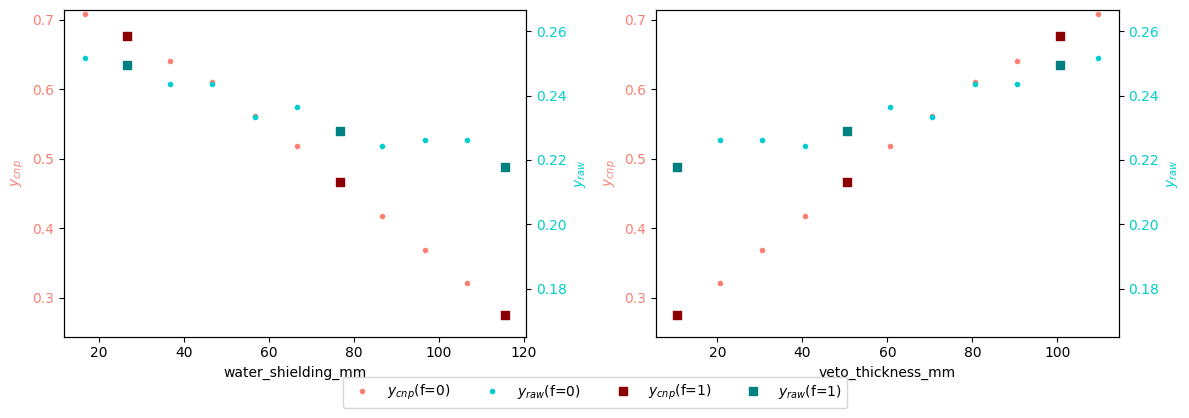

In [ ]:
# Generate marginalized plots for all parameters
try:
    fig = plotting.get_marginialized_all(config_file=config_file)
    fig.savefig(f'{path_out}/cnp_{version}_output.png', dpi=300, bbox_inches='tight')
    print(f"Marginalized plots saved to: {path_out}/cnp_{version}_output.png")
except Exception as e:
    print(f"Error generating marginalized plots: {e}")
    import traceback
    traceback.print_exc()

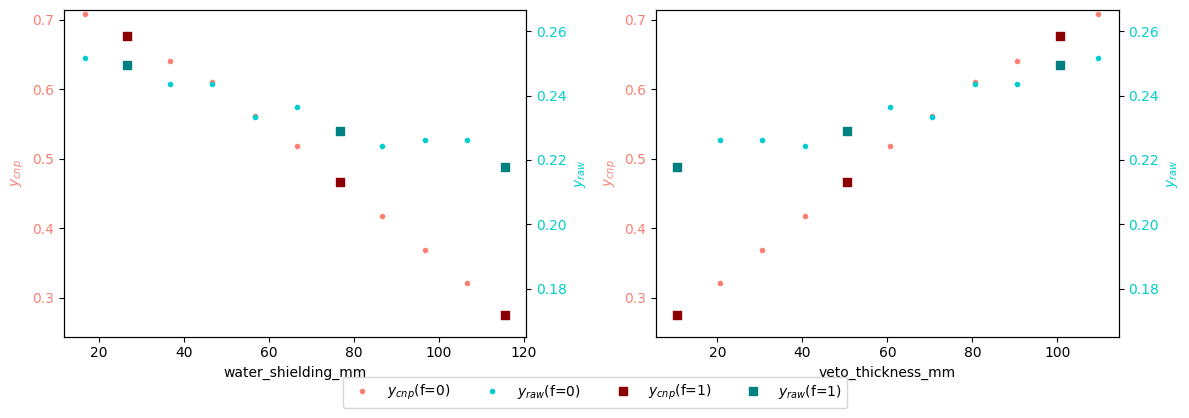

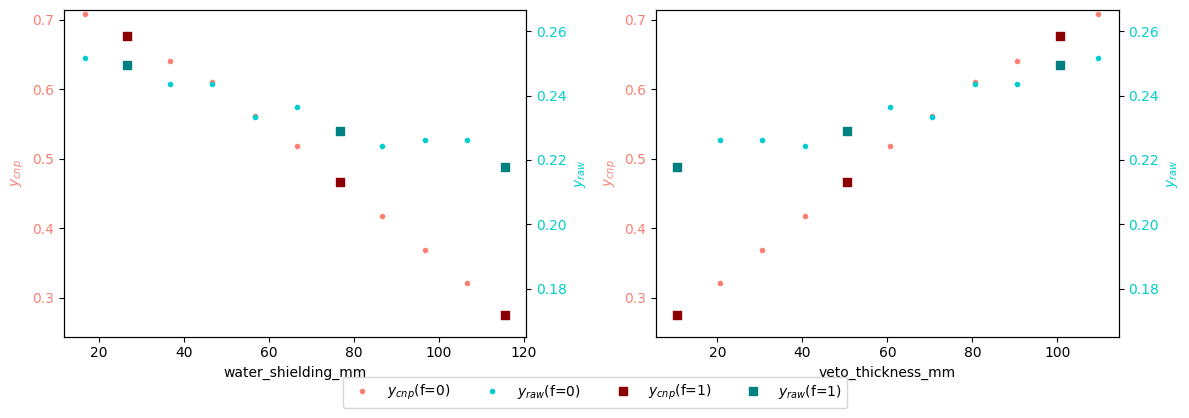

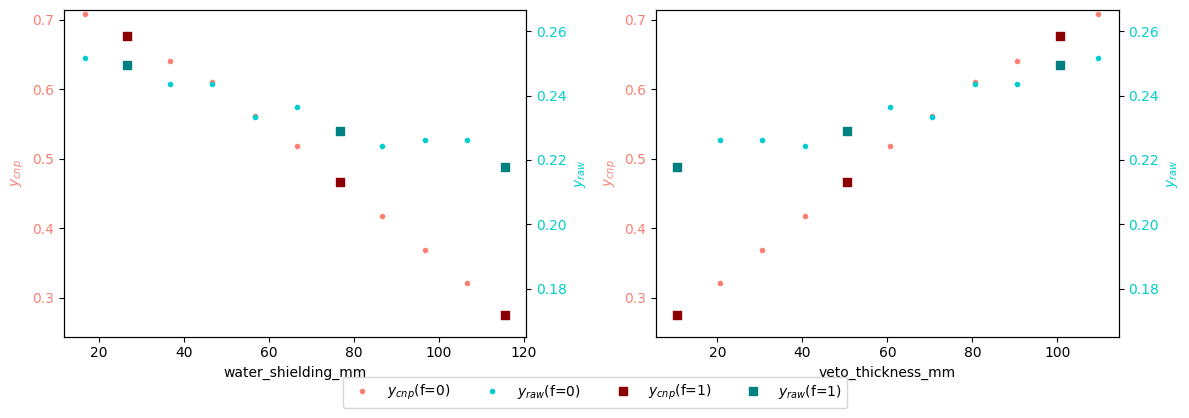

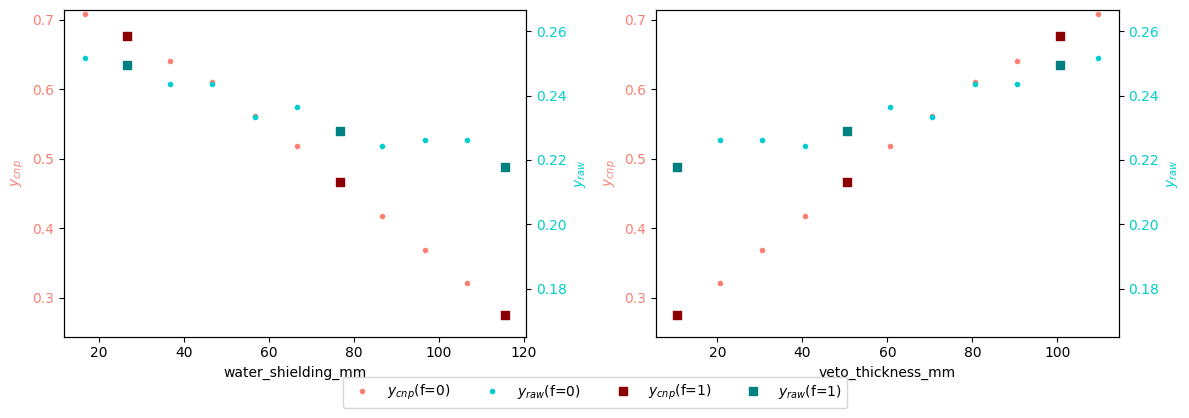

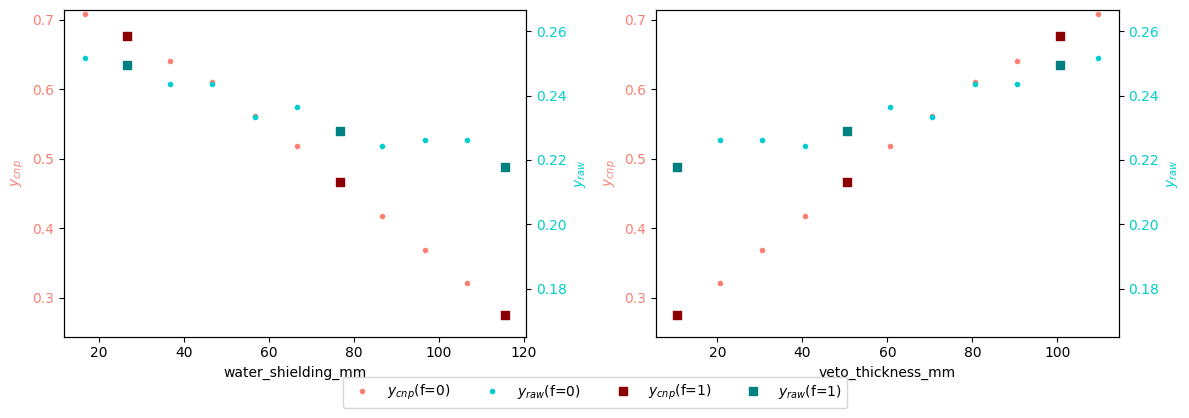

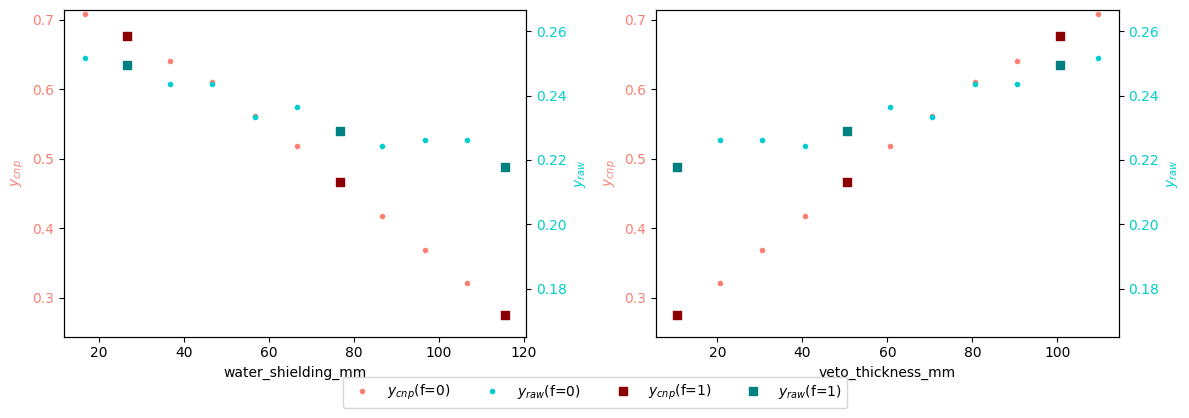

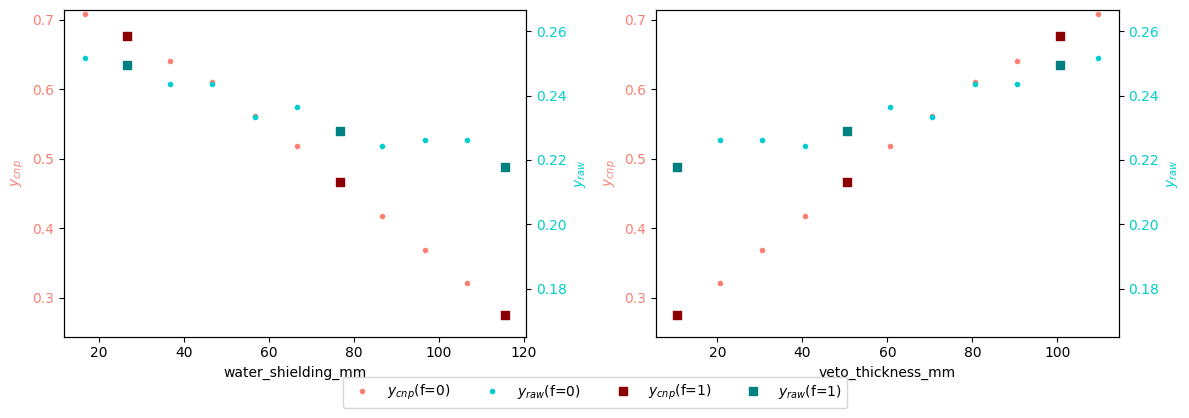

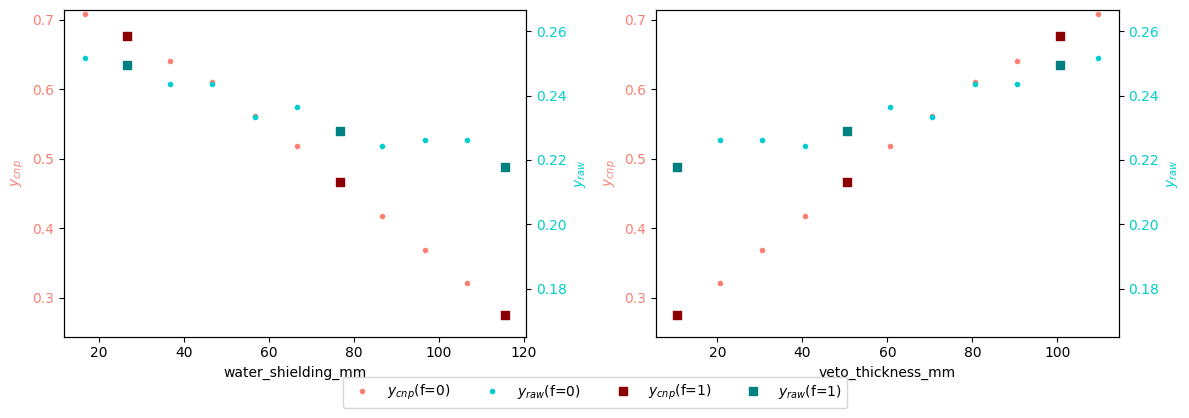

In [5]:
# troubleshooting
import pandas as pd
x_labels = config_file["simulation_settings"]["theta_headers"]
x_min = config_file["simulation_settings"]["theta_min"]
x_max = config_file["simulation_settings"]["theta_max"]
path_out  = config_file["path_settings"]["path_out_cnp"]
version   = config_file["path_settings"]["version"]
data=pd.read_csv(f'{path_out}/cnp_{version}_output.csv')
y_label_sim = 'y_raw'
y_label_cnp = 'y_cnp'
fidelities  = np.unique(config_file["path_settings"]["fidelity"])
x_data = []
y_data = []
y_sim = []
y_data_min=1.
y_data_max=0.
y_sim_min=1.
y_sim_max=0.

In [8]:
data['iteration'].max()

0.0

In [6]:
fidelities

array([0, 1])

In [10]:
data.loc[(data['fidelity']==1)][x_labels].to_numpy()

array([], shape=(0, 2), dtype=float64)

In [ ]:
# troubleshooting 2
for f in fidelities:
    x_data.append(data.loc[(data['fidelity']==f)][x_labels].to_numpy())
    y_data.append(data.loc[(data['fidelity']==f)][y_label_cnp].to_numpy())
    y_sim.append(data.loc[(data['fidelity']==f)][y_label_sim].to_numpy())
    y_data_min=min(y_data_min,np.min(y_data[-1]))
    y_data_max=max(y_data_max,np.max(y_data[-1]))
    y_sim_min=min(y_sim_min,np.min(y_sim[-1]))
    y_sim_max=max(y_sim_max,np.max(y_sim[-1]))